## Cross-validation

K-fold Cross-validation —  метод проверки производительности нашей модели. Он оценивает модель, используя различные чанки данных в качестве тестового набора.

Мы делим наш набор данных на K-фолдов, на которые мы хотим разделить датасет. Если мы используем 5 фолдов, набор данных делится на пять разделов. В разных итерациях одна часть становится проверочным набором.


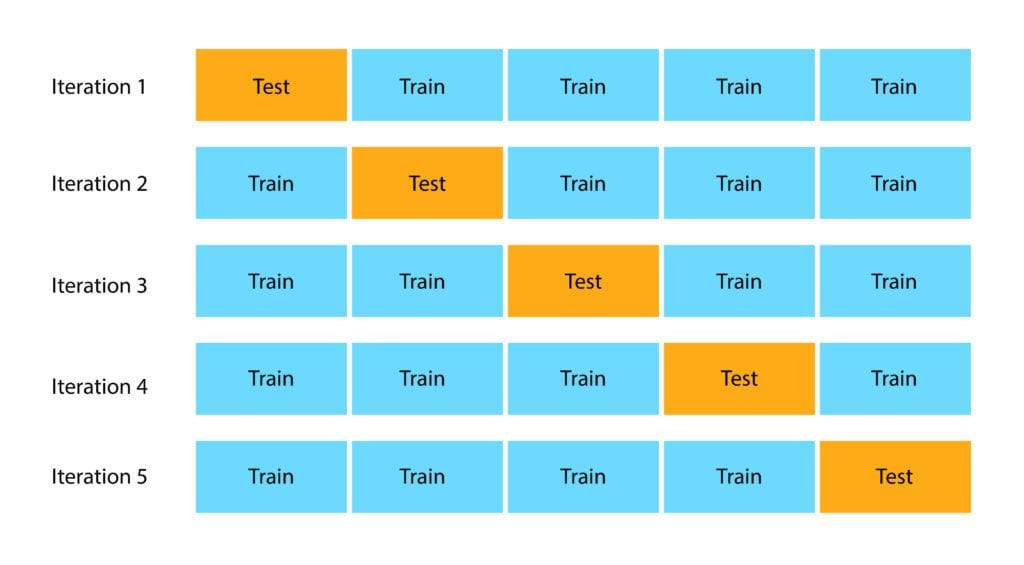

После применения k-Fold для одной модели у нас будет k экземпляров этой модели, обученных на разных подмножествах. Возможные варианты:

* делать предсказание с помощью усреднения предсказаний этих инстансов
* из этих инстансов выбрать тот, который набрал лучший скор на своём тестовом фолде, и применять дальше его
* заново обучить модель уже на всех k фолдах и делать предсказания уже этой моделью

Выбирать, какой способ лучше, нужно в зависимости от конкретной задачи и имеющихся вычислительных возможностей.

Метод k-Fold даёт более надёжную оценку качества модели, чем hold-out, так как обучение и тест модели происходят на разных подмножествах исходного датасета. Однако проведение k итераций обучения и теста может быть вычислительно затратным, и поэтому метод обычно применяют либо когда данных достаточно мало, либо при наличии большого количества вычислительных ресурсов, позволяющих проводить все k итераций параллельно. В реальных задачах данных зачастую достаточно много для того, чтобы hold-out давал хорошую оценку качества модели, поэтому k-Fold в больших задачах применяется не очень часто.

## Имплементация

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def cross_validation(model, X, y, k = 5):
    X_train_folds = np.array_split(X, k)
    y_train_folds = np.array_split(y, k)
    scores = []

    for i in range(k):
        X_test = X_train_folds[i]
        y_test = y_train_folds[i]
        X_train = np.vstack((X_train_folds[0:i]+X_train_folds[i+1:]))
        y_train = np.vstack((y_train_folds[0:i]+y_train_folds[i+1:])).ravel()

        model.fit(X_train, y_train)
        scores.append(model.score(X_test, y_test))
        y_pred = model.predict(X_test)

    return scores

## Grid Search & Grid Search + CV

Grid Search нужен для подбора гиперпараметров модели. Если заранее неизвестно, какими могут быть оптимальные значения, приходится искать по сетке значений. Если у нас есть m гиперпараметров и для каждого задано n возможных значений, то число вариантов равно mn и для каждого нужно обучить модель и определить ее точность. Если мы используем перекрестную проверку (cross-validation), то это число надо умножить на число частей, на которые мы разбиваем набор данных.

## Имплементация

In [3]:
import itertools
from sklearn.model_selection import train_test_split

def grid_search(model, param_grid, X, y):
    best_score = -float('inf')
    best_params = None
    
    param_combinations = itertools.product(*param_grid.values())

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    scores = []
    for params in param_combinations:
        for param_name, param_value in zip(param_grid.keys(), params):
            setattr(model, param_name, param_value)
        
        model.fit(X_train, y_train)
        scores.append(model.score(X_test, y_test))
        mean_score = np.mean(scores)
        
        if mean_score > best_score:
            best_score = mean_score
            best_params = params
    
    return best_score, dict(zip(param_grid.keys(), best_params))

In [4]:
def grid_search_cv(model, param_grid, X, y, cv=5):
    best_score = -float('inf')
    best_params = None

    param_combinations = np.array(np.meshgrid(*param_grid.values())).T.reshape(-1, len(param_grid))

    for params in param_combinations:
        for param_name, param_value in zip(param_grid.keys(), params):
            setattr(model, param_name, param_value)

        scores = cross_validation(model, X, y, k=cv)
        mean_score = np.mean(scores)

        if mean_score > best_score:
            best_score = mean_score
            best_params = params
    
    return best_score, dict(zip(param_grid.keys(), best_params))

## Датасет

In [5]:
!wget -O 'train.csv' -q 'https://www.dropbox.com/s/tcvwgixnh9ixecd/car_price_pred.csv?dl=0'

In [6]:
train = pd.read_csv('train.csv')
train.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [7]:
train.isnull().any()

car_ID              False
symboling           False
CarName             False
fueltype            False
aspiration          False
doornumber          False
carbody             False
drivewheel          False
enginelocation      False
wheelbase           False
carlength           False
carwidth            False
carheight           False
curbweight          False
enginetype          False
cylindernumber      False
enginesize          False
fuelsystem          False
boreratio           False
stroke              False
compressionratio    False
horsepower          False
peakrpm             False
citympg             False
highwaympg          False
price               False
dtype: bool

In [8]:
train.dtypes

car_ID                int64
symboling             int64
CarName              object
fueltype             object
aspiration           object
doornumber           object
carbody              object
drivewheel           object
enginelocation       object
wheelbase           float64
carlength           float64
carwidth            float64
carheight           float64
curbweight            int64
enginetype           object
cylindernumber       object
enginesize            int64
fuelsystem           object
boreratio           float64
stroke              float64
compressionratio    float64
horsepower            int64
peakrpm               int64
citympg               int64
highwaympg            int64
price               float64
dtype: object

In [9]:
y = train['price']
X = train.drop(columns=['price'])

In [10]:
numeric_data = X.select_dtypes([np.number])
numeric_features = numeric_data.columns

categ_data = X.select_dtypes([np.object0])
cat_features = categ_data.columns

In [11]:
mean_encode = train.groupby('CarName')['price'].mean()
train.loc[:, 'CarName_mean_enc'] = train['CarName'].map(mean_encode)

mean_encode = train.groupby('fueltype')['price'].mean()
train.loc[:, 'fueltype_mean_enc'] = train['fueltype'].map(mean_encode)

mean_encode = train.groupby('aspiration')['price'].mean()
train.loc[:, 'aspiration_mean_enc'] = train['aspiration'].map(mean_encode)

mean_encode = train.groupby('doornumber')['price'].mean()
train.loc[:, 'doornumber_mean_enc'] = train['doornumber'].map(mean_encode)

mean_encode = train.groupby('carbody')['price'].mean()
train.loc[:, 'carbody_mean_enc'] = train['carbody'].map(mean_encode)

mean_encode = train.groupby('drivewheel')['price'].mean()
train.loc[:, 'drivewheel_mean_enc'] = train['drivewheel'].map(mean_encode)

mean_encode = train.groupby('enginelocation')['price'].mean()
train.loc[:, 'enginelocation_mean_enc'] = train['enginelocation'].map(mean_encode)

mean_encode = train.groupby('enginetype')['price'].mean()
train.loc[:, 'enginetype_mean_enc'] = train['enginetype'].map(mean_encode)

mean_encode = train.groupby('cylindernumber')['price'].mean()
train.loc[:, 'cylindernumber_mean_enc'] = train['cylindernumber'].map(mean_encode)

mean_encode = train.groupby('fuelsystem')['price'].mean()
train.loc[:, 'fuelsystem_mean_enc'] = train['fuelsystem'].map(mean_encode)

In [12]:
y = train['price']
X = train.drop(columns=['price'])

In [13]:
X = X.drop(columns = cat_features)

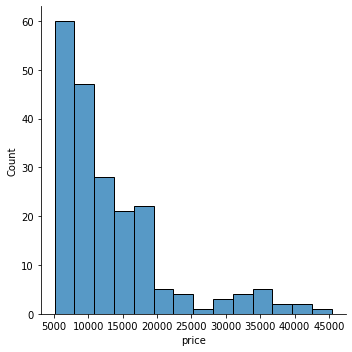

In [14]:
sns.displot(y)

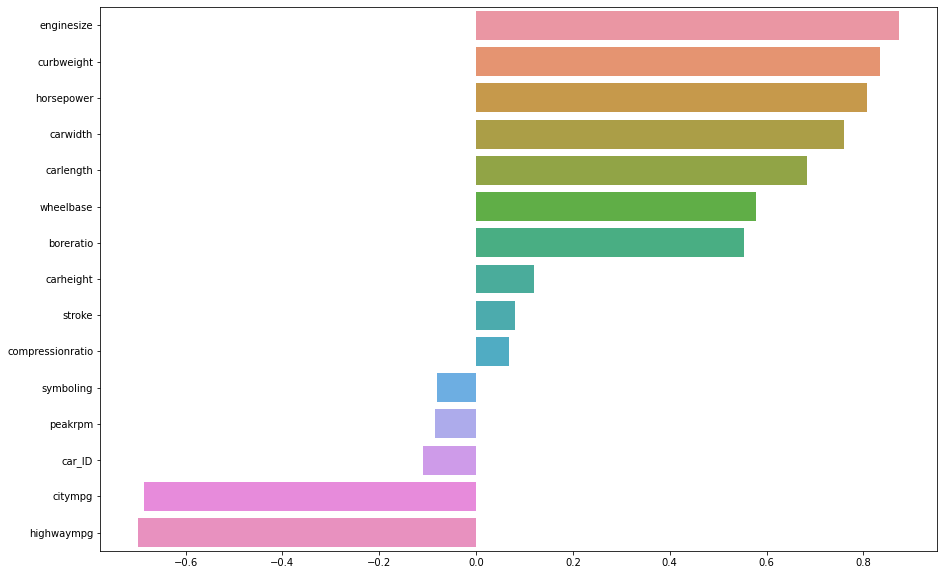

In [15]:
correlations = X[numeric_features].corrwith(y).sort_values(ascending=False)

plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(15, 10)

## Обучение

In [16]:
from sklearn.tree import DecisionTreeRegressor

In [17]:
model = DecisionTreeRegressor(criterion='squared_error', max_depth=10, min_samples_split=5)

### My Cross-validation

In [18]:
scores = cross_validation(model = model, X = X, y = y, k = 5)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature nam

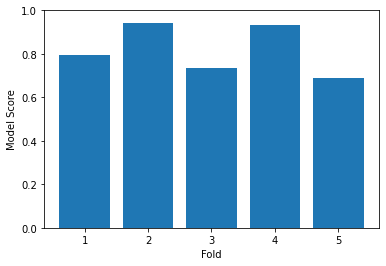

In [19]:
fig, ax = plt.subplots()
ax.bar(np.arange(1, len(scores)+1), scores)
ax.set_xlabel('Fold')
ax.set_ylabel('Model Score')
ax.set_ylim([0, 1])
ax.set_xticks(np.arange(1, len(scores)+1))
plt.show()

### Sklearn Cross-validation

In [20]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate, GridSearchCV

In [21]:
results = cross_validate(estimator=model,
                         X = X,
                         y = y,
                         cv=5)

In [22]:
scores = results["test_score"]

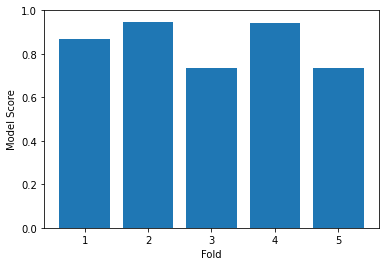

In [23]:
fig, ax = plt.subplots()
ax.bar(np.arange(1, len(scores)+1), scores)
ax.set_xlabel('Fold')
ax.set_ylabel('Model Score')
ax.set_ylim([0, 1])
ax.set_xticks(np.arange(1, len(scores)+1))
plt.show()

Графики идентичные

### My Grid Search

In [24]:
param_grid = {'criterion': ['absolute_error', 'squared_error', 'poisson', 'friedman_mse'], 
              'max_depth': [3, 5, 7, 10, 15, None], 
              'min_samples_split': [2, 5, 10, 20], 
              'min_samples_leaf': [1, 2, 4, 8]}

best_score, best_params = grid_search(model, param_grid, X, y)

print('Best score:', best_score)
print('Best parameters:', best_params)

Best score: 0.9045601515151568
Best parameters: {'criterion': 'absolute_error', 'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 4}


## My Grid Search + CV

In [25]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
best_score, best_params = grid_search_cv(model, param_grid, X, y, cv = 5)

print('Best score:', best_score)
print('Best parameters:', best_params)

Best score: 0.8923951992698846
Best parameters: {'criterion': 'friedman_mse', 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 1}


## Sklearn Grid Search

In [27]:
search = GridSearchCV(model, param_grid, cv=5)
search.fit(X, y)

print('Best score:', search.best_score_)
print('Best parameters:', search.best_params_)

Best score: 0.8873959848161952
Best parameters: {'criterion': 'friedman_mse', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}


## Затестим Catboost, Xgboost, LightGBM

In [30]:
import catboost
import xgboost
import lightgbm

In [31]:
model1 = catboost.CatBoostRegressor(loss_function='RMSE', random_state=42)
model2 = xgboost.XGBRegressor(objective='reg:squarederror', random_state=42)
model3 = lightgbm.LGBMRegressor(objective='regression', random_state=42)

In [34]:
param_grid1 = {'learning_rate': [0.01, 0.1],
              'depth': [4, 8],
              'l2_leaf_reg': [3, 5, 7]}


param_grid2 = {'learning_rate': [0.01, 0.1],
              'max_depth': [5, 7],
              'min_child_weight': [3, 5],
              'n_estimators': [100, 200]}

param_grid3 = {'learning_rate': [0.01, 0.1],
              'max_depth': [5, 7],
              'min_child_samples': [5, 10],
              'n_estimators': [100, 200]}

### My Grid Search

In [35]:
best_score, best_params = grid_search_cv(model1, param_grid1, X, y, cv = 5)

print('Best score:', best_score)
print('Best parameters:', best_params)

Выходные данные были обрезаны до нескольких последних строк (5000).
6:	learn: 6819.9216953	total: 9.97ms	remaining: 1.41s
7:	learn: 6693.2720094	total: 11.3ms	remaining: 1.4s
8:	learn: 6579.3560829	total: 12.9ms	remaining: 1.42s
9:	learn: 6457.4958350	total: 14.2ms	remaining: 1.41s
10:	learn: 6362.3716930	total: 15.5ms	remaining: 1.4s
11:	learn: 6237.5556039	total: 16.9ms	remaining: 1.39s
12:	learn: 6126.3613429	total: 18.4ms	remaining: 1.4s
13:	learn: 6019.8763084	total: 19.8ms	remaining: 1.39s
14:	learn: 5903.6998414	total: 21.1ms	remaining: 1.39s
15:	learn: 5797.6941292	total: 24.1ms	remaining: 1.48s
16:	learn: 5692.7340927	total: 26.8ms	remaining: 1.55s
17:	learn: 5601.1593964	total: 29.3ms	remaining: 1.6s
18:	learn: 5500.4645994	total: 31.9ms	remaining: 1.65s
19:	learn: 5403.6908795	total: 35.2ms	remaining: 1.72s
20:	learn: 5306.6436294	total: 36.3ms	remaining: 1.69s
21:	learn: 5213.9028356	total: 37.4ms	remaining: 1.66s
22:	learn: 5124.9672680	total: 38.5ms	remaining: 1.64s
23:	l

### Sklearn Grid Search

In [38]:
search = GridSearchCV(model1, param_grid1, cv=5)
search.fit(X, y)

print('Best score:', search.best_score_)
print('Best parameters:', search.best_params_)

Выходные данные были обрезаны до нескольких последних строк (5000).
2:	learn: 5864.5640317	total: 9.78ms	remaining: 3.25s
3:	learn: 5621.5404261	total: 13.1ms	remaining: 3.25s
4:	learn: 5398.8328058	total: 16.3ms	remaining: 3.24s
5:	learn: 5146.8258677	total: 19.4ms	remaining: 3.22s
6:	learn: 4982.8077878	total: 22.5ms	remaining: 3.19s
7:	learn: 4757.4030108	total: 25.6ms	remaining: 3.17s
8:	learn: 4589.5761736	total: 28.8ms	remaining: 3.17s
9:	learn: 4391.2724926	total: 31.9ms	remaining: 3.15s
10:	learn: 4252.4091964	total: 33.2ms	remaining: 2.98s
11:	learn: 4102.9706448	total: 36.3ms	remaining: 2.99s
12:	learn: 3976.4878356	total: 39.4ms	remaining: 2.99s
13:	learn: 3805.1460665	total: 42.5ms	remaining: 3s
14:	learn: 3633.8453029	total: 45.6ms	remaining: 3s
15:	learn: 3522.6385741	total: 48.7ms	remaining: 2.99s
16:	learn: 3384.5214055	total: 51.9ms	remaining: 3s
17:	learn: 3271.5648760	total: 52.7ms	remaining: 2.88s
18:	learn: 3168.3889381	total: 56.1ms	remaining: 2.9s
19:	learn: 3088

In [39]:
search = GridSearchCV(model2, param_grid2, cv=5)
search.fit(X, y)

print('Best score:', search.best_score_)
print('Best parameters:', search.best_params_)

Best score: 0.8881887951858373
Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 100}


In [40]:
search = GridSearchCV(model3, param_grid3, cv=5)
search.fit(X, y)

print('Best score:', search.best_score_)
print('Best parameters:', search.best_params_)

Best score: 0.9054162641261705
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 5, 'n_estimators': 100}
